In [2]:
#- 祝日・曜日効果の活用
#add_country_holidays() を使って祝日をモデルに組み込むと精度が上がります。
#- 外部要因の追加
#気温、湿度、感染症の流行指数などを add_regressor() で追加すると、季節性以上の変動も捉えられるようになります。
#- 異常値の処理
#MSEがやや高めなのは、突発的な需要急増（例：パンデミック初期）による外れ値の影響かも。cap や floor を設定して予測範囲を制限するのも有効です。


In [3]:
import pandas as pd
import seaborn as sns

In [4]:
#Optunaをインストール
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.4/247.4 kB 21.7 MB/s eta 0:00:00


In [5]:
import optuna

In [ ]:
# 3. データの準備

In [7]:
df = pd.read_excel('/content/p-data.xlsx')
df

,日付,A,B
0,2011-01-01,4,4
1,2011-01-02,3,4
2,2011-01-03,5,0
3,2011-01-04,10,6
4,2011-01-05,7,2
...,...,...,...
5321,2025-07-27,0,1
5322,2025-07-28,11,6
5323,2025-07-29,8,6
5324,2025-07-30,7,3


In [8]:
# データの整形
df_A = df[['日付', 'A']].rename(columns={'日付': 'ds', 'A': 'y'})
df_B = df[['日付', 'B']].rename(columns={'日付': 'ds', 'B': 'y'})

<Axes: xlabel='日付', ylabel='A'>

/usr/local/lib/python3.12/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 26085 (\N{CJK UNIFIED IDEOGRAPH-65E5}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 20184 (\N{CJK UNIFIED IDEOGRAPH-4ED8}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 26085 (\N{CJK UNIFIED IDEOGRAPH-65E5}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20184 (\N{CJK UNIFIED IDEOGRAPH-4ED8}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


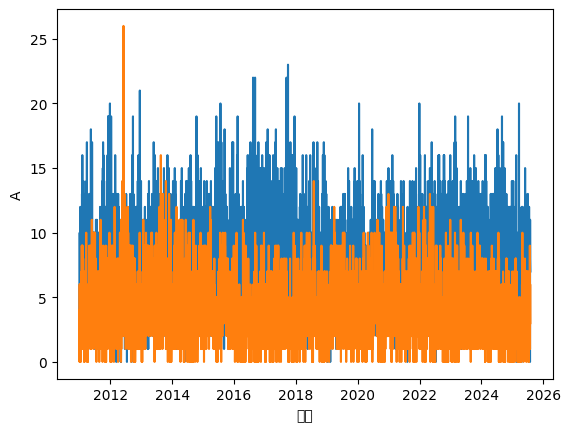

In [9]:
# 折れ線グラフで可視化
time = pd.to_datetime(df['日付'])
sns.lineplot(x=time, y=df['A'])
sns.lineplot(x=time, y=df['B'])

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5326 entries, 0 to 5325
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   日付      5326 non-null   datetime64[ns]
 1   A       5326 non-null   int64         
 2   B       5326 non-null   int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 125.0 KB


In [11]:
# 4. 予測モデルの学習

In [12]:
# 引数(seasonality_mode='multiplicative') →周期性変動が徐々に拡大する予測モデル
from prophet import Prophet
## model = Prophet(seasonality_mode='multiplicative')
from prophet.diagnostics import cross_validation, performance_metrics

In [13]:
# []はリスト
cutoffs = pd.to_datetime(['2019-3-31', '2022-3-31'])

In [14]:
def objective_A(trial):
    # 試行ごとに変化させたいパラメータをsuggestする
    changepoint_prior_scale = trial.suggest_float('changepoint_prior_scale', 0.001, 0.5, log=True)
    seasonality_prior_scale = trial.suggest_float('seasonality_prior_scale', 0.01, 10, log=True)
    # seasonality_modeは固定でもOKですが、試してみたい場合は以下のようにもできます
    seasonality_mode = trial.suggest_categorical('seasonality_mode', ['additive', 'multiplicative'])

    # Prophetモデルをパラメータ付きで定義
    model_A = Prophet(    ##ダブり
        changepoint_prior_scale=changepoint_prior_scale,
        seasonality_prior_scale=seasonality_prior_scale,
        seasonality_mode=seasonality_mode
    )
    model_A.fit(df_A)   ##ダブり

    # cross-validationでテスト性能を評価
    df_cv_A = cross_validation(model_A, horizon='1096 days', cutoffs=cutoffs, parallel="processes")   ##ダブり
    df_p_A = performance_metrics(df_cv_A)   ##ダブり

    # MAE（平均絶対誤差）を使って評価
    return df_p_A['mae'].mean()

# Optunaで最適化
study_A = optuna.create_study(direction='minimize')
study_A.optimize(objective_A, n_trials=30)  # n_trialsは試行回数


[I 2025-08-29 10:22:18,262] A new study created in memory with name: no-name-dc413c04-ce7c-49b3-a05e-7c038405962f
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6076q_lq/hqe6ewau.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6076q_lq/zgtam4qa.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=30315', 'data', 'file=/tmp/tmp6076q_lq/hqe6ewau.json', 'init=/tmp/tmp6076q_lq/zgtam4qa.json', 'output', 'file=/tmp/tmp6076q_lq/prophet_modelugejlqpj/prophet_model-20250829102219.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:22:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:22:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Applying in par

In [15]:
def objective_B(trial):
    # 試行ごとに変化させたいパラメータをsuggestする
    changepoint_prior_scale = trial.suggest_float('changepoint_prior_scale', 0.001, 0.5, log=True)
    seasonality_prior_scale = trial.suggest_float('seasonality_prior_scale', 0.01, 10, log=True)
    # seasonality_modeは固定でもOKですが、試してみたい場合は以下のようにもできます
    seasonality_mode = trial.suggest_categorical('seasonality_mode', ['additive', 'multiplicative'])

    # Prophetモデルをパラメータ付きで定義
    model_B = Prophet(    ##ダブり
        changepoint_prior_scale=changepoint_prior_scale,
        seasonality_prior_scale=seasonality_prior_scale,
        seasonality_mode=seasonality_mode
    )
    model_B.fit(df_B)   ##ダブり

    # cross-validationでテスト性能を評価
    df_cv_B = cross_validation(model_B, horizon='1096 days', cutoffs=cutoffs, parallel="processes")   ##ダブり
    df_p_B = performance_metrics(df_cv_B)   ##ダブり

    # MAE（平均絶対誤差）を使って評価
    return df_p_B['mae'].mean()

# Optunaで最適化
study_B = optuna.create_study(direction='minimize')
study_B.optimize(objective_B, n_trials=30)  # n_trialsは試行回数

[I 2025-08-29 10:23:26,028] A new study created in memory with name: no-name-2d5fa8c4-a08c-4895-8609-3ba0bd10eae6
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6076q_lq/r1ktx5mn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6076q_lq/jywe4_7a.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21883', 'data', 'file=/tmp/tmp6076q_lq/r1ktx5mn.json', 'init=/tmp/tmp6076q_lq/jywe4_7a.json', 'output', 'file=/tmp/tmp6076q_lq/prophet_modellrcngwml/prophet_model-20250829102326.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:23:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:23:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Applying in par

In [16]:
# 最適なパラメータを取得
best_params_A = study_A.best_params
best_params_B = study_B.best_params

# Prophetモデルを再構築
model_A = Prophet(
    changepoint_prior_scale=best_params_A['changepoint_prior_scale'],
    #changepoint_prior_scale=0.5,   #値が小さい程、トレンドは滑らかになり、過去の傾向を重視(推奨:0.001～0.5)
    seasonality_prior_scale=best_params_A['seasonality_prior_scale'],
    seasonality_mode=best_params_A['seasonality_mode'],
    #changepoint_range=0.95  #値が大きいほど、最近のデータに重点を置いて変化点を探す(推奨:0.8～0.95)
)
model_A.fit(df_A)
model_B = Prophet(
    changepoint_prior_scale=best_params_B['changepoint_prior_scale'],
    #changepoint_prior_scale=0.5,   #値が小さい程、トレンドは滑らかになり、過去の傾向を重視(推奨:0.001～0.5)
    seasonality_prior_scale=best_params_B['seasonality_prior_scale'],
    seasonality_mode=best_params_B['seasonality_mode'],
    #changepoint_range=0.95  #値が大きいほど、最近のデータに重点を置いて変化点を探す(推奨:0.8～0.95)
)
model_B.fit(df_B)

# クロスバリデーションと性能評価
df_cv_A = cross_validation(model_A, horizon='1096 days', cutoffs=cutoffs, parallel="processes")
df_p_A = performance_metrics(df_cv_A)
df_cv_B = cross_validation(model_B, horizon='1096 days', cutoffs=cutoffs, parallel="processes")
df_p_B = performance_metrics(df_cv_B)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6076q_lq/2ospak66.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6076q_lq/3_dqsls_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=42047', 'data', 'file=/tmp/tmp6076q_lq/2ospak66.json', 'init=/tmp/tmp6076q_lq/3_dqsls_.json', 'output', 'file=/tmp/tmp6076q_lq/prophet_modelfp7l0m9f/prophet_model-20250829102439.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:24:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:24:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp60

In [17]:
print('ベストパラメータ:', study_A.best_params)
print('ベストパラメータ:', study_B.best_params)


ベストパラメータ: {'changepoint_prior_scale': 0.032464922125928906, 'seasonality_prior_scale': 0.09762553891196415, 'seasonality_mode': 'multiplicative'}
ベストパラメータ: {'changepoint_prior_scale': 0.0018006619424041472, 'seasonality_prior_scale': 0.024086048045012447, 'seasonality_mode': 'additive'}


<Axes: xlabel='horizon', ylabel='mse'>

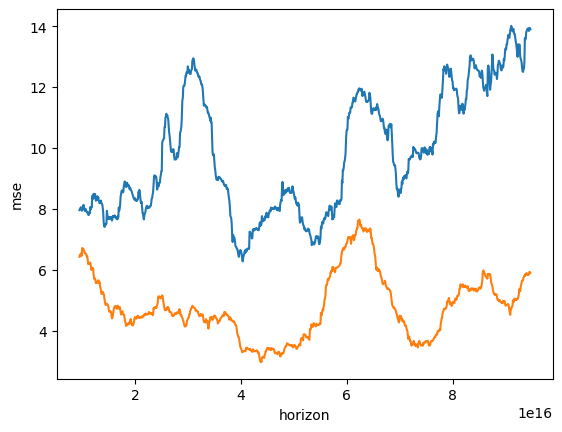

In [18]:
# プロット
sns.lineplot(x='horizon', y='mse', data=df_p_A)
sns.lineplot(x='horizon', y='mse', data=df_p_B)

<Axes: xlabel='horizon', ylabel='mae'>

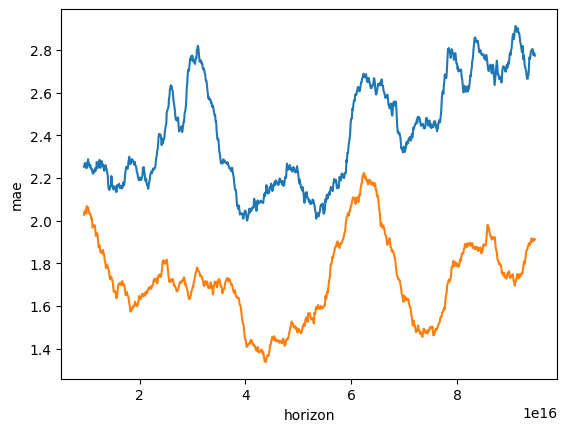

In [19]:
# プロット
sns.lineplot(x='horizon', y='mae', data=df_p_A)
sns.lineplot(x='horizon', y='mae', data=df_p_B)

In [20]:
# 5. 予測

In [21]:
# 予測の事前準備
# 予測したい未来日時を含むDataFrameを作成する必要
# 予測期間を指定してmake_future_dataframeメソッドを実行→未来日時を含むDataFrameの枠組みを作成
#
#  make_future_dataframe(パラメータ)
#  　・periods　予測期間として追加する行数
#　　・freq　　 'D'	 1日
#　　　　　　　 'M'	 1か月（追加される日時データは、月の最終日となる）
#　　　　　     'MS' 1か月（追加される日時データは、月の初日となる）
#　　　　　     'H'	 1時間

future_A = model_A.make_future_dataframe(periods=61, freq='D')
future_B = model_B.make_future_dataframe(periods=61, freq='D')

In [22]:
forecast_A = model_A.predict(future_A)
forecast_B = model_B.predict(future_B)

In [23]:
# model.predict 機械学習データが新しいデータに対して予測を行う
forecast_A.tail(61)  #最後の61件だけ表示
forecast_B.tail(61)

# yhat予測値（モデルが予測した値）
# trend  　　 モデルが推定した長期的な傾向
# yhat_lower　予測値の下限（信頼区間の下限）
# yhat_upper  予測値の上限（信頼区間の上限）
# trend_lower トレンドの下限（不確実性含む）
# trend_upper トレンドの上限（不確実性含む）

# trend_lowerとtrend_upperが同じ値→トレンドの不確実性を無視する設定になっている
# 不確実性を含めたい場合は、model = Prophet(uncertainty_samples=1000)に戻してモデルを再構築する


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
5326,2025-08-01,3.640225,2.596413,8.040388,3.640225,3.640225,1.631041,1.631041,1.631041,1.458880,1.458880,1.458880,0.172161,0.172161,0.172161,0.0,0.0,0.0,5.271266
5327,2025-08-02,3.640081,-0.281683,5.038844,3.640081,3.640081,-1.220471,-1.220471,-1.220471,-1.365711,-1.365711,-1.365711,0.145240,0.145240,0.145240,0.0,0.0,0.0,2.419610
5328,2025-08-03,3.639937,-0.607888,5.100431,3.639937,3.639937,-1.560650,-1.560650,-1.560650,-1.677277,-1.677277,-1.677277,0.116627,0.116627,0.116627,0.0,0.0,0.0,2.079287
5329,2025-08-04,3.639793,2.068719,7.757811,3.639793,3.639793,1.265213,1.265213,1.265213,1.178289,1.178289,1.178289,0.086925,0.086925,0.086925,0.0,0.0,0.0,4.905006
5330,2025-08-05,3.639649,1.124359,6.430407,3.639649,3.639649,0.196818,0.196818,0.196818,0.140058,0.140058,0.140058,0.056760,0.056760,0.056760,0.0,0.0,0.0,3.836467
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5382,2025-09-26,3.632154,2.294336,7.873758,3.632154,3.632154,1.513219,1.513219,1.513219,1.458880,1.458880,1.458880,0.054339,0.054339,0.054339,0.0,0.0,0.0,5.145373
5383,2025-09-27,3.632010,-0.597507,4.995802,3.632010,3.632010,-1.341420,-1.341420,-1.341420,-1.365711,-1.365711,-1.365711,0.024291,0.024291,0.024291,0.0,0.0,0.0,2.290591
5384,2025-09-28,3.631866,-0.650079,4.766825,3.631866,3.631866,-1.682189,-1.682189,-1.682189,-1.677277,-1.677277,-1.677277,-0.004912,-0.004912,-0.004912,0.0,0.0,0.0,1.949677
5385,2025-09-29,3.631722,2.027153,7.589594,3.631722,3.631722,1.145150,1.145150,1.145150,1.178289,1.178289,1.178289,-0.033138,-0.033138,-0.033138,0.0,0.0,0.0,4.776872


In [24]:
#A_8m9m = forecast_A.tail(61)
#A_8m9m.to_excel('A_8m9m.xlsx', index=False)
#B_8m9m = forecast_B.tail(61)
#B_8m9m.to_excel('B_8m9m.xlsx', index=False)

In [25]:
forecast_A[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
# ds	日付
# yhat	予測値
# yhat_lower	予測値の不確実性区間の下限
# yhat_upper	予測値の不確実性区間の上限

,ds,yhat,yhat_lower,yhat_upper
0,2011-01-01,4.771003,1.315743,8.888828
1,2011-01-02,4.497786,0.872777,8.611860
2,2011-01-03,8.700204,4.916322,12.476041
3,2011-01-04,7.557236,3.892674,11.232921
4,2011-01-05,8.034336,4.265965,11.666459
...,...,...,...,...
5382,2025-09-26,10.562541,7.048573,14.036087
5383,2025-09-27,5.578538,1.922508,9.299215
5384,2025-09-28,5.253314,1.306290,8.779826
5385,2025-09-29,9.762460,6.307267,13.526469


In [26]:
forecast_B[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

,ds,yhat,yhat_lower,yhat_upper
0,2011-01-01,2.503162,-0.148110,5.192209
1,2011-01-02,2.126831,-0.719430,5.099950
2,2011-01-03,4.922801,2.011105,7.704716
3,2011-01-04,3.831209,1.128872,6.504953
4,2011-01-05,4.022043,1.228910,6.778066
...,...,...,...,...
5382,2025-09-26,5.145373,2.294336,7.873758
5383,2025-09-27,2.290591,-0.597507,4.995802
5384,2025-09-28,1.949677,-0.650079,4.766825
5385,2025-09-29,4.776872,2.027153,7.589594


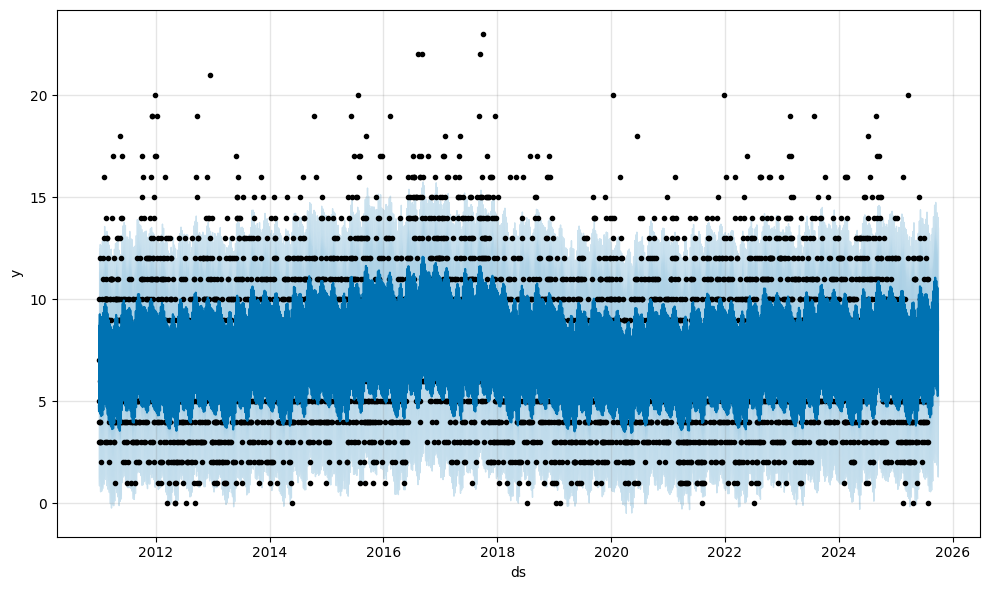

In [27]:
fig_forecast_A = model_A.plot(forecast_A)
#黒点が実際の値、青ラインが予測モデルによる予測値、水色のエリアが予測値の不確実性区間

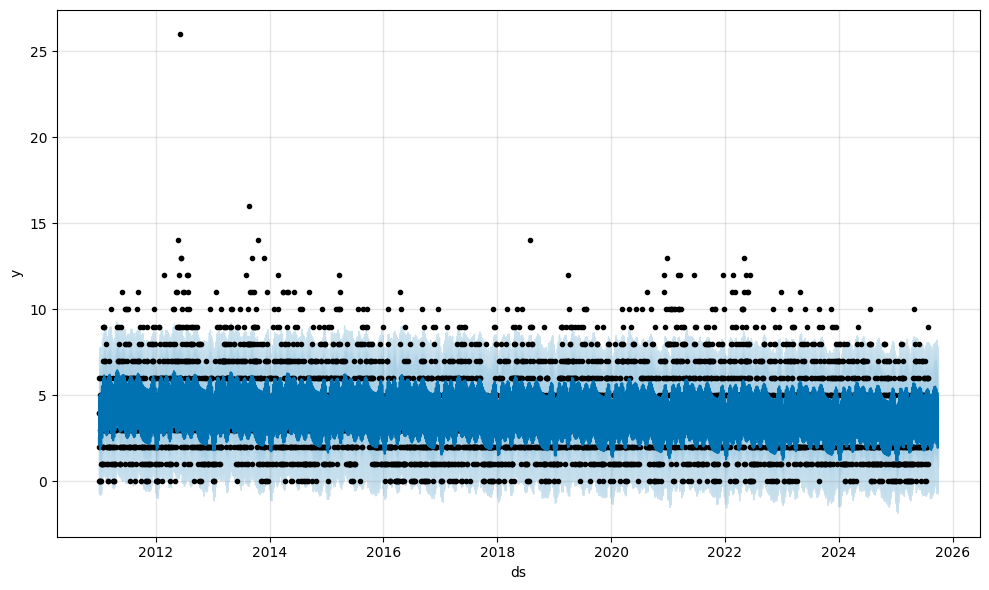

In [28]:
fig_forecast_B = model_B.plot(forecast_B)
##黒点が実際の値、青ラインが予測モデルによる予測値、水色のエリアが予測値の不確実性区間

In [ ]:
# 6. 予測の評価

In [ ]:
# cutoffs   いつまでのデータを学習データとするかという期限の日付
# horizon   cutoffs翌日以降のテスト期間

In [29]:
# []はリスト
cutoffs = pd.to_datetime(['2019-3-31', '2022-3-31'])

In [30]:
# cross_validation関数:交差検証(データを複数回分割して繰り返し評価)
from prophet.diagnostics import cross_validation

In [31]:
# テスト期間は3年(365×3+1(閏年))
df_cv_A = cross_validation(model_A, horizon = '1096 days', cutoffs=cutoffs)
df_cv_B = cross_validation(model_B, horizon = '1096 days', cutoffs=cutoffs)

  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp6076q_lq/hj7a8gjw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6076q_lq/s8ynjypo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12940', 'data', 'file=/tmp/tmp6076q_lq/hj7a8gjw.json', 'init=/tmp/tmp6076q_lq/s8ynjypo.json', 'output', 'file=/tmp/tmp6076q_lq/prophet_modelbgx9t852/prophet_model-20250829102518.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:25:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:25:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6076q_lq/hrlpcn51.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6076q_lq/wi7rshse.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp6076q_lq/aykgw6ln.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6076q_lq/n_n15h7f.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=55229', 'data', 'file=/tmp/tmp6076q_lq/aykgw6ln.json', 'init=/tmp/tmp6076q_lq/n_n15h7f.json', 'output', 'file=/tmp/tmp6076q_lq/prophet_modelvfp_6d35/prophet_model-20250829102519.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:25:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:25:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6076q_lq/hdpqfwbt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6076q_lq/0vkc_vly.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

In [32]:
df_cv_A

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2019-04-01,8.175548,4.588249,11.924366,8,2019-03-31
1,2019-04-02,7.093238,3.505297,10.892336,6,2019-03-31
2,2019-04-03,7.520421,3.675735,11.015482,7,2019-03-31
3,2019-04-04,6.537911,2.755924,10.208628,10,2019-03-31
4,2019-04-05,8.734026,5.058281,12.449783,5,2019-03-31
...,...,...,...,...,...,...
2187,2025-03-27,5.717665,1.901322,9.453998,4,2022-03-31
2188,2025-03-28,7.841230,4.107350,11.732462,8,2022-03-31
2189,2025-03-29,3.741645,-0.040484,7.179852,2,2022-03-31
2190,2025-03-30,3.563479,-0.340347,7.138551,3,2022-03-31


In [33]:
# 評価指標を算出
from prophet.diagnostics import performance_metrics

In [34]:
df_p_A = performance_metrics(df_cv_A)
df_p_B = performance_metrics(df_cv_B)

df_p_A.head()

# mse	     平均二乗誤差(誤差が大きいほど、指標の値も大きい。値が小さいほど良いモデル)
# rmse     二乗平均平方根誤差(〃)
# mae      平均絶対誤差(〃)
# mape     平均絶対パーセント誤差(〃)
# mdape	   メディアン絶対パーセント誤差(〃)
# smape    対称平均絶対パーセント誤差(〃)
# coverage 不確実性区間に予測値が含まれている割合

INFO:prophet:Skipping MAPE because y close to 0
INFO:prophet:Skipping MAPE because y close to 0


,horizon,mse,rmse,mae,mdape,smape,coverage
0,110 days,7.957308,2.820870,2.252620,0.275526,0.366910,0.808219
1,111 days,7.991932,2.827001,2.261051,0.275526,0.367067,0.808219
2,112 days,8.021933,2.832302,2.266910,0.279740,0.366150,0.808219
3,113 days,8.052872,2.837758,2.270193,0.275526,0.365910,0.803653
4,114 days,8.014705,2.831025,2.260828,0.275526,0.366480,0.805936


<Axes: xlabel='horizon', ylabel='mse'>

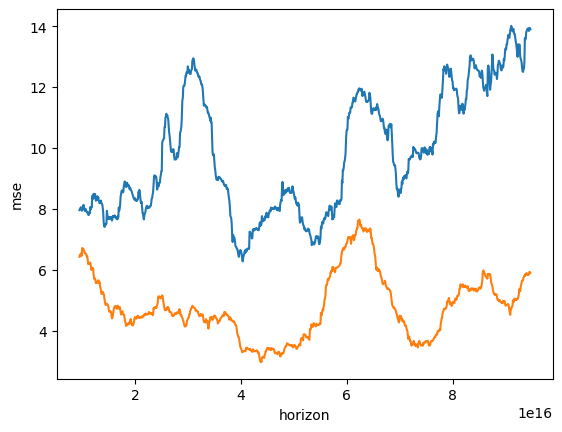

In [35]:
# 実際の値と予測値の平均二乗誤差であるmseの推移を可視化(horizon:テストデータ区間)
sns.lineplot(x='horizon', y='mse', data=df_p_A)
sns.lineplot(x='horizon', y='mse', data=df_p_B)

<Axes: xlabel='horizon', ylabel='coverage'>

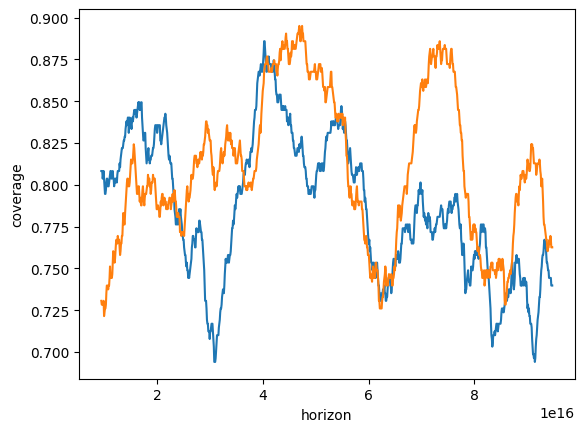

In [36]:
# 不確実性区間に予測値が含まれている割合であるcoverageを推移を可視化(テストデータ区間)
sns.lineplot(x='horizon', y='coverage', data=df_p_A)
sns.lineplot(x='horizon', y='coverage', data=df_p_B)

In [37]:
# 補足：予測モデルの構成要素の確認

In [38]:
print(df_A['ds'].min(), df_A['ds'].max())


2011-01-01 00:00:00 2025-07-31 00:00:00


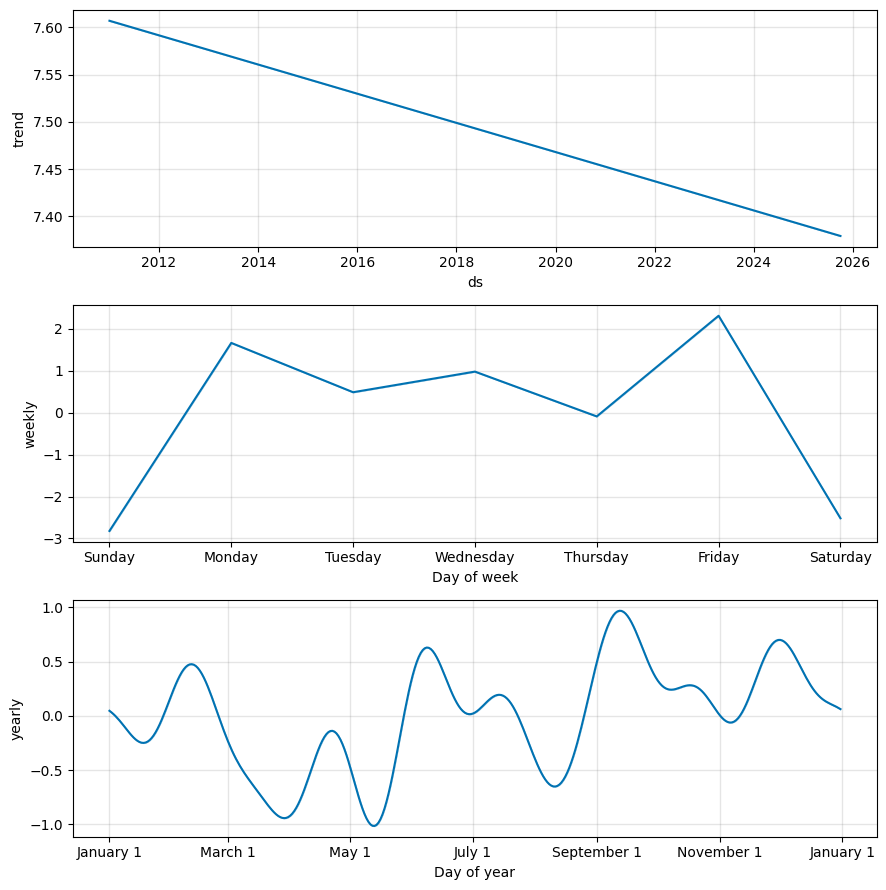

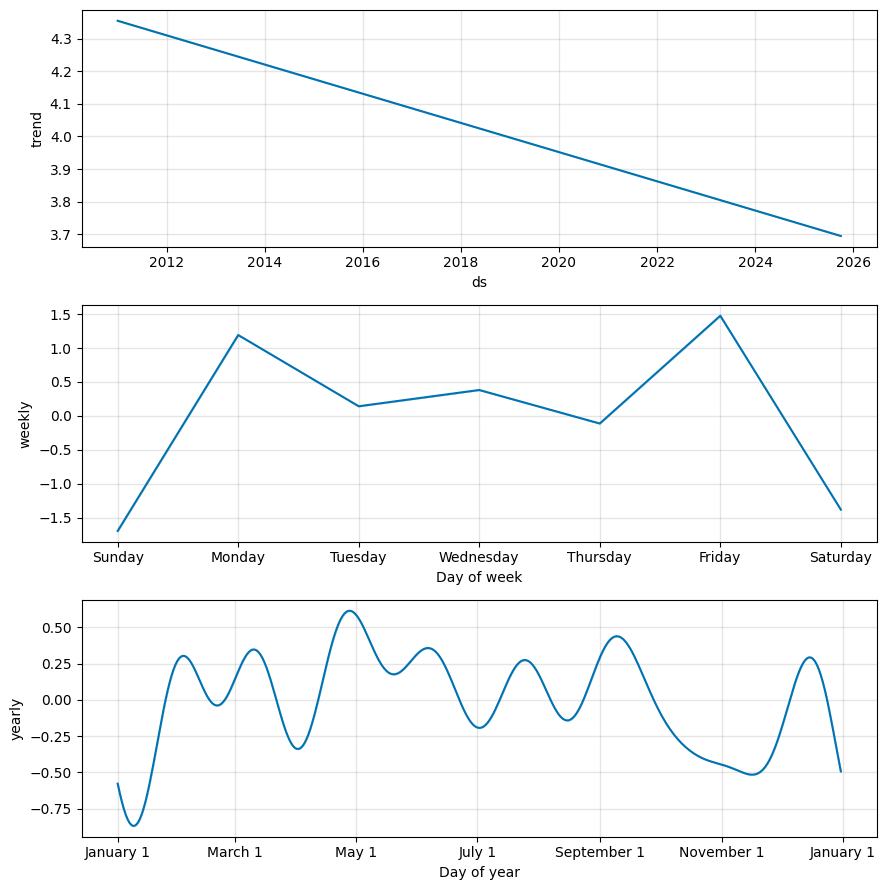

In [ ]:
# 長期トレンド（上側の図）と年間の周期変動（下側の図）
fig_components_A = model_A.plot_components(forecast_A)
fig_components_B = model_B.plot_components(forecast_B)

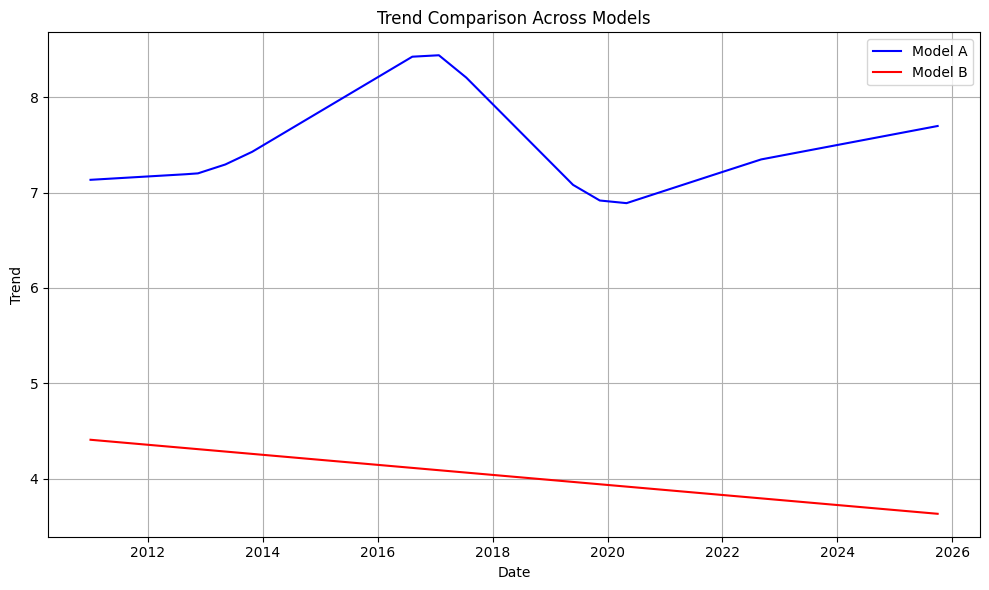

In [39]:
import matplotlib.pyplot as plt

# 各モデルのトレンド成分を取得
trend_A = forecast_A[['ds', 'trend']]
trend_B = forecast_B[['ds', 'trend']]

# グラフ描画
plt.figure(figsize=(10, 6))
plt.plot(trend_A['ds'], trend_A['trend'], label='Model A', color='blue')
plt.plot(trend_B['ds'], trend_B['trend'], label='Model B', color='red')

plt.title('Trend Comparison Across Models')
plt.xlabel('Date')
plt.ylabel('Trend')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
